In [2]:
pip install keras==2.9.0 

   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   -- ------------------------------------- 0.1/1.6 MB 5.5 MB/s eta 0:00:01
   ------ --------------------------------- 0.3/1.6 MB 4.0 MB/s eta 0:00:01
   ------------- -------------------------- 0.5/1.6 MB 4.2 MB/s eta 0:00:01
   ------------------ --------------------- 0.7/1.6 MB 4.3 MB/s eta 0:00:01
   ----------------------- ---------------- 1.0/1.6 MB 4.4 MB/s eta 0:00:01
   ----------------------------- ---------- 1.2/1.6 MB 4.5 MB/s eta 0:00:01
   ---------------------------------- ----- 1.4/1.6 MB 4.7 MB/s eta 0:00:01
   -------------------------------------- - 1.6/1.6 MB 4.4 MB/s eta 0:00:01
   ---------------------------------------- 1.6/1.6 MB 4.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.10.1 requires keras<2.11,>=2.10.0, but you have keras 2.9.0 which is incompatible.
tensorflow 2.10.1 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
tensorflow-intel 2.16.1 requires keras>=3.0.0, but you have keras 2.9.0 which is incompatible.
tensorflow-intel 2.16.1 requires tensorboard<2.17,>=2.16, but you have tensorboard 2.10.1 which is incompatible.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers
from keras.datasets import mnist



In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
        print(e)
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
import tensorflow as tf
from tensorflow.python.client import device_lib

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Device List: ", device_lib.list_local_devices())


Num GPUs Available:  1
Device List:  [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11217470964281786991
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4160159744
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1963065783747245751
physical_device_desc: "device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [6]:
import tensorflow as tf
import timeit

# Utwórz macierz i wykonaj operację na CPU i GPU
with tf.device('/CPU:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(128, 3)(random_image_cpu)

with tf.device('/GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(128, 3)(random_image_gpu)

print("CPU: ", timeit.timeit(lambda: tf.keras.layers.Conv2D(128, 3)(random_image_cpu), number=10))
print("GPU: ", timeit.timeit(lambda: tf.keras.layers.Conv2D(128, 3)(random_image_gpu), number=10))

CPU:  0.19313739999995505
GPU:  0.1827127000000246


In [7]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

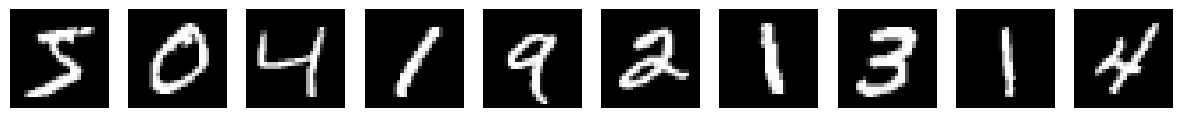

In [8]:
num_images = 10
plt.figure(figsize=(15, 5))
for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.axis('off')
plt.show()

In [9]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train = np.reshape(x_train, (-1, 28, 28, 1))
x_test = np.reshape(x_test, (-1, 28, 28, 1))

In [10]:
latent_dim = 2
input_shape = (28, 28, 1)

# Budowa enkodera
encoder_inputs = tf.keras.Input(shape=input_shape)
x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

In [11]:
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.keras.backend.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])


In [12]:
decoder_inputs = tf.keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation='relu')(decoder_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)

encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
decoder = tf.keras.Model(decoder_inputs, decoder_outputs, name='decoder')

In [13]:
vae_outputs = decoder(encoder(encoder_inputs)[2])
vae = tf.keras.Model(encoder_inputs, vae_outputs, name='vae')

reconstruction_loss = tf.keras.losses.binary_crossentropy(tf.keras.backend.flatten(encoder_inputs), tf.keras.backend.flatten(vae_outputs))
reconstruction_loss *= 28 * 28
kl_loss = 1 + z_log_var - tf.keras.backend.square(z_mean) - tf.keras.backend.exp(z_log_var)
kl_loss = tf.keras.backend.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = tf.keras.backend.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

vae.fit(x_train, epochs=100, batch_size=128, validation_data=(x_test, None))

Epoch 1/100
469/469 [==============================] - 10s 15ms/step - loss: 216.0923 - val_loss: 189.1418
Epoch 2/100
469/469 [==============================] - 6s 13ms/step - loss: 171.7859 - val_loss: 165.7869
Epoch 3/100
469/469 [==============================] - 6s 14ms/step - loss: 162.5750 - val_loss: 160.4707
Epoch 4/100
469/469 [==============================] - 6s 13ms/step - loss: 159.3546 - val_loss: 157.8726
Epoch 5/100
469/469 [==============================] - 7s 14ms/step - loss: 157.4705 - val_loss: 156.9214
Epoch 6/100
469/469 [==============================] - 7s 14ms/step - loss: 156.2940 - val_loss: 155.5856
Epoch 7/100
469/469 [==============================] - 7s 15ms/step - loss: 155.3548 - val_loss: 154.4100
Epoch 8/100
469/469 [==============================] - 7s 15ms/step - loss: 154.5475 - val_loss: 154.1142
Epoch 9/100
469/469 [==============================] - 7s 15ms/step - loss: 153.9531 - val_loss: 153.4803
Epoch 10/100
469/469 [=======================

1/1 [==============================] - 0s 24ms/step


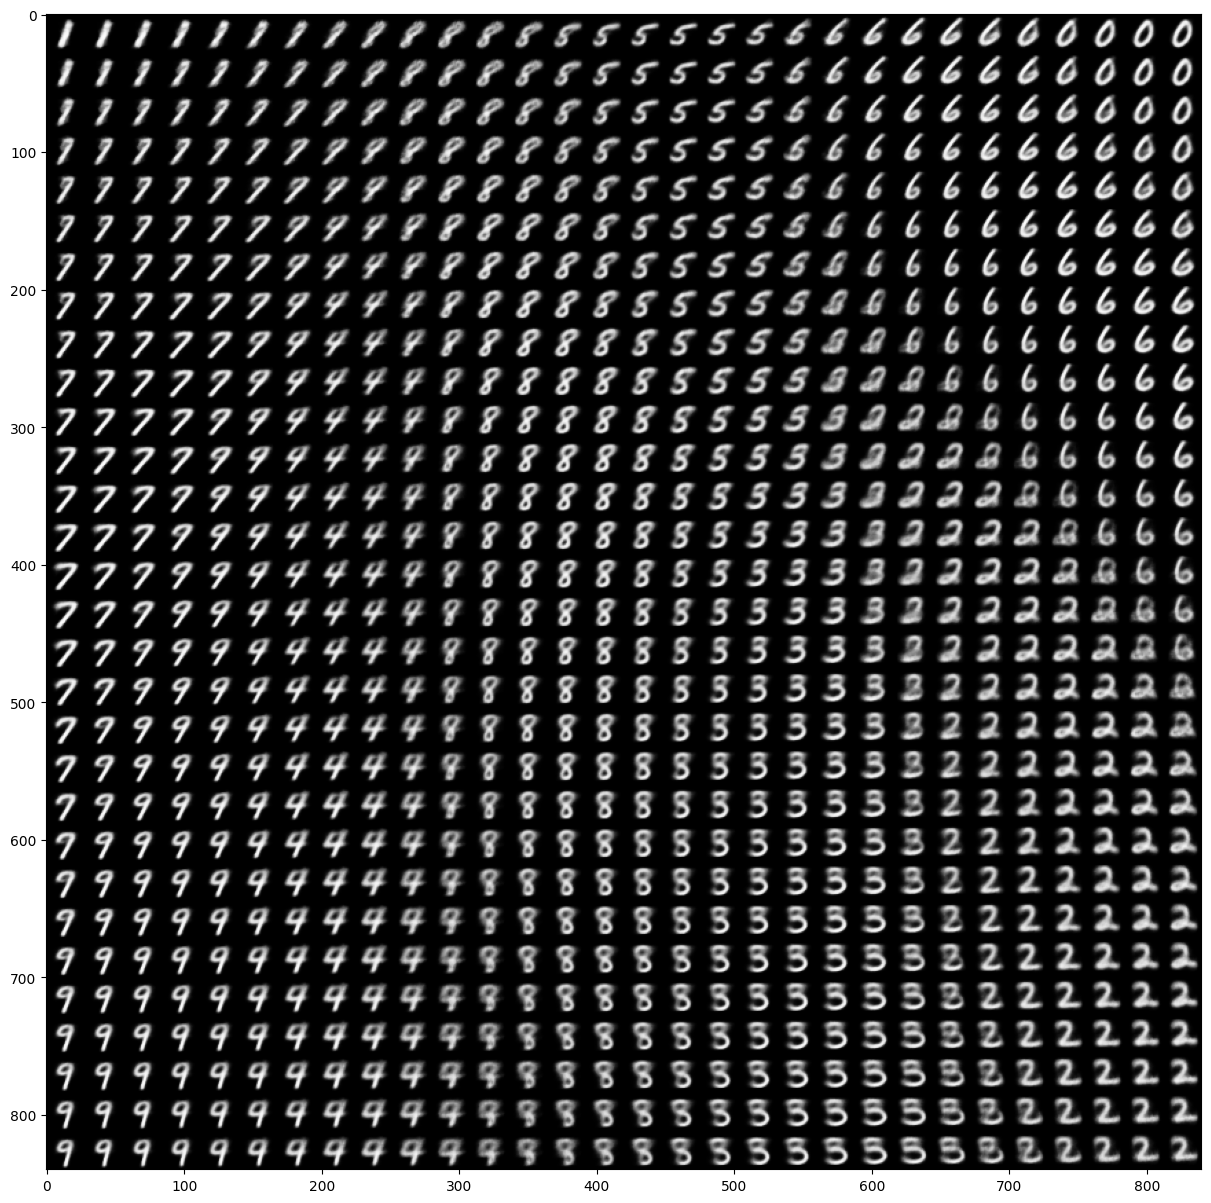

In [15]:
def plot_latent_space(vae, n=30, figsize=15):
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

# Wyświetlenie wygenerowanych cyfr
plot_latent_space(vae)

313/313 [==============================] - 1s 2ms/step


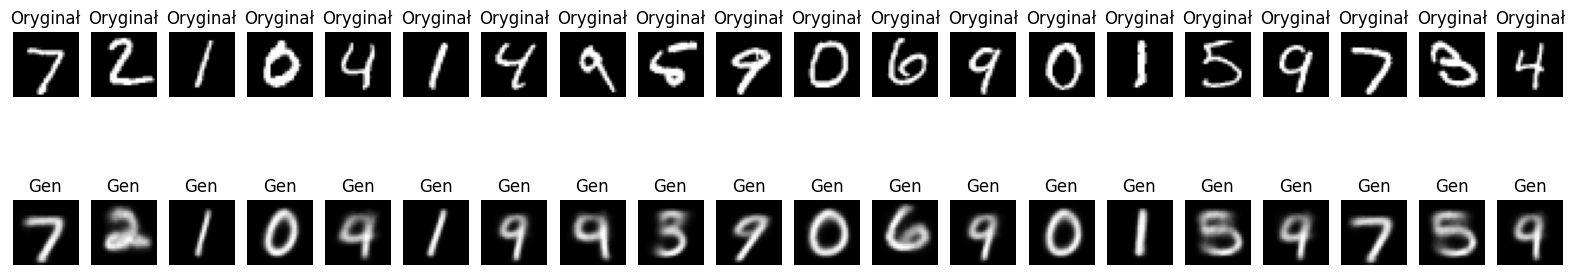

In [16]:
encoded_imgs = encoder.predict(x_test)[2]
decoded_imgs = decoder.predict(encoded_imgs)

num_images = 20
plt.figure(figsize=(20, 4))
for i in range(num_images):
    # Oryginalne obrazy
    ax = plt.subplot(2, num_images, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Oryginał")
    plt.axis('off')

    # Wygenerowane obrazy
    ax = plt.subplot(2, num_images, i + 1 + num_images)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("Gen")
    plt.axis('off')

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Reshape
from keras.optimizers import Adam

In [ ]:
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Zmiana kształtu danych do postaci [ilość, wysokość, szerokość, liczba kanałów]
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))


In [ ]:
# Wymiary wejściowe obrazów
input_img = Input(shape=(28, 28, 1))

# Część enkodera
x = Flatten()(input_img)
x = Dense(128, activation='relu')(x)
encoded = Dense(64, activation='relu')(x)

# Część dekodera
x = Dense(128, activation='relu')(encoded)
x = Dense(28 * 28, activation='sigmoid')(x)
decoded = Reshape((28, 28, 1))(x)

# Stworzenie modelu autoencodera
autoencoder = Model(input_img, decoded)

# Kompilacja modelu
autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')


In [5]:
autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))


Epoch 1/50
235/235 [==============================] - 4s 7ms/step - loss: 0.2209 - val_loss: 0.1413
Epoch 2/50
235/235 [==============================] - 2s 7ms/step - loss: 0.1262 - val_loss: 0.1136
Epoch 3/50
235/235 [==============================] - 1s 6ms/step - loss: 0.1084 - val_loss: 0.1016
Epoch 4/50
235/235 [==============================] - 2s 7ms/step - loss: 0.1001 - val_loss: 0.0958
Epoch 5/50
235/235 [==============================] - 2s 7ms/step - loss: 0.0950 - val_loss: 0.0918
Epoch 6/50
235/235 [==============================] - 2s 6ms/step - loss: 0.0915 - val_loss: 0.0889
Epoch 7/50
235/235 [==============================] - 1s 6ms/step - loss: 0.0890 - val_loss: 0.0867
Epoch 8/50
235/235 [==============================] - 2s 7ms/step - loss: 0.0870 - val_loss: 0.0852
Epoch 9/50
235/235 [==============================] - 1s 6ms/step - loss: 0.0856 - val_loss: 0.0840
Epoch 10/50
235/235 [==============================] - 1s 5ms/step - loss: 0.0841 - val_loss: 0.0825

313/313 [==============================] - 1s 2ms/step


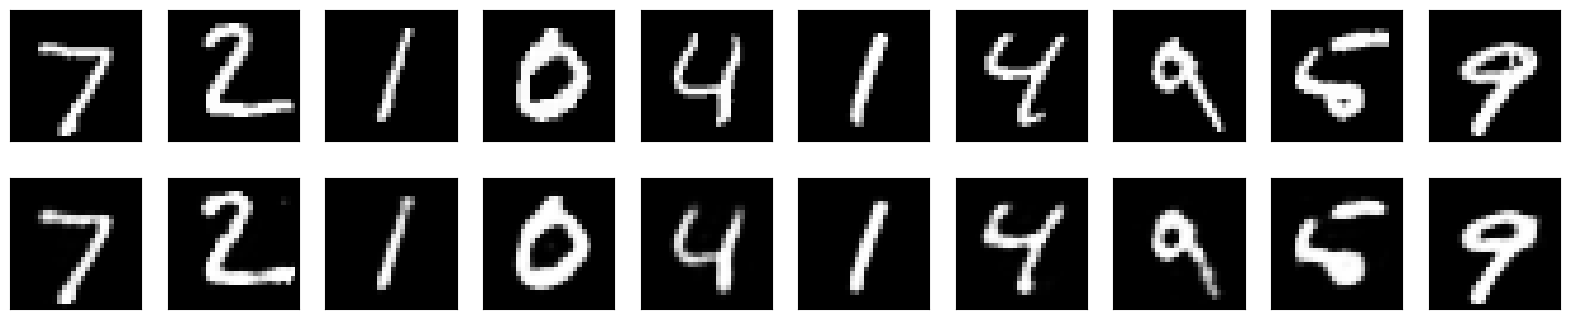

In [6]:
# Generowanie zakodowanych i odkodowanych obrazów
encoded_imgs = autoencoder.predict(x_test)
decoded_imgs = autoencoder.predict(encoded_imgs)

# Wizualizacja wyników
n = 10  # liczba obrazów do wyświetlenia
plt.figure(figsize=(20, 4))
for i in range(n):
    # Wyświetlenie oryginalnych obrazów
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Wyświetlenie odkodowanych obrazów
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [22]:
latent_dim = 2  # Dimensionality of the latent space
input_shape = (28, 28, 1)  # Shape of MNIST images

# Encoder
encoder_inputs = tf.keras.Input(shape=input_shape)

x = layers.Conv2D(32, (5, 5), activation='relu', strides=(2, 2), padding='same')(encoder_inputs)
x = layers.Conv2D(64, (5, 5), activation='relu', strides=(2, 2), padding='same')(x)
x = layers.Conv2D(128, (5, 5), activation='relu', strides=(2, 2), padding='valid')(x)
x = layers.Dropout(0.1)(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)

# Variational layers
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.keras.backend.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# Define encoder model
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

# Decoder
decoder_inputs = tf.keras.Input(shape=(latent_dim,))
x = layers.Dense(128, activation='relu')(decoder_inputs)
x = layers.Reshape((1, 1, 128))(x)
x = layers.Conv2DTranspose(128, (7, 7), activation='relu', strides=(1, 1), padding='valid')(x)
x = layers.Conv2DTranspose(64, (7, 7), activation='relu', strides=(2, 2), padding='same')(x)
x = layers.Conv2DTranspose(32, (7, 7), activation='relu', strides=(2, 2), padding='same')(x)
decoder_outputs = layers.Conv2DTranspose(1, (7, 7), activation='sigmoid', padding='same')(x)

# Define decoder model
decoder = tf.keras.Model(decoder_inputs, decoder_outputs, name='decoder')

# VAE model
vae_outputs = decoder(z)
vae = tf.keras.Model(encoder_inputs, vae_outputs, name='vae')

# Flatten inputs for binary cross-entropy
flat_encoder_inputs = tf.keras.layers.Flatten()(encoder_inputs)
flat_vae_outputs = tf.keras.layers.Flatten()(vae_outputs)

# Define VAE loss
reconstruction_loss = tf.keras.losses.binary_crossentropy(flat_encoder_inputs, flat_vae_outputs)
reconstruction_loss *= input_shape[0] * input_shape[1]  # Multiply by image dimensions

kl_loss = 1 + z_log_var - tf.keras.backend.square(z_mean) - tf.keras.backend.exp(z_log_var)
kl_loss = tf.keras.backend.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = tf.keras.backend.mean(reconstruction_loss + kl_loss)

# Compile VAE
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

# Load and preprocess MNIST data
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_train = tf.expand_dims(x_train, -1)

# Training
vae.fit(x_train, epochs=100, batch_size=128, validation_split=0.2)


Epoch 1/100
375/375 [==============================] - 17s 40ms/step - loss: 187.4874 - val_loss: 159.7363
Epoch 2/100
375/375 [==============================] - 17s 46ms/step - loss: 156.2808 - val_loss: 152.8397
Epoch 3/100
375/375 [==============================] - 17s 44ms/step - loss: 151.2585 - val_loss: 148.6081
Epoch 4/100
375/375 [==============================] - 17s 46ms/step - loss: 148.5210 - val_loss: 146.4549
Epoch 5/100
375/375 [==============================] - 18s 48ms/step - loss: 146.7221 - val_loss: 145.0478
Epoch 6/100
375/375 [==============================] - 19s 50ms/step - loss: 145.5087 - val_loss: 143.5728
Epoch 7/100
375/375 [==============================] - 20s 52ms/step - loss: 144.4376 - val_loss: 143.9241
Epoch 8/100
375/375 [==============================] - 22s 60ms/step - loss: 143.6721 - val_loss: 142.4472
Epoch 9/100
375/375 [==============================] - 20s 55ms/step - loss: 142.8755 - val_loss: 142.3449
Epoch 10/100
375/375 [===============

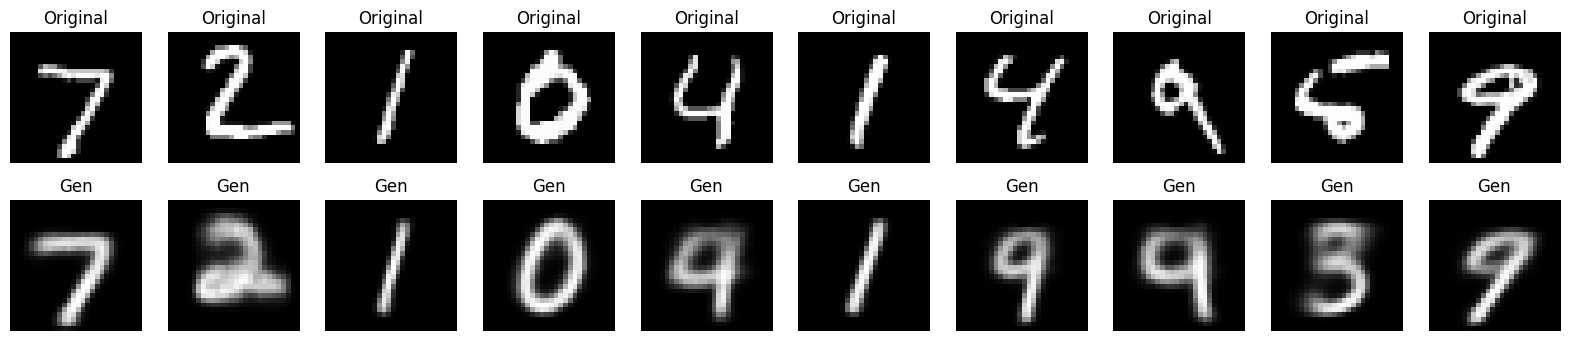

In [24]:
def plot_images(original_imgs, decoded_imgs, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original images
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original_imgs[i].reshape(28, 28), cmap='gray')
        plt.title('Original')
        plt.axis('off')
        
        # Display decoded images
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
        plt.title('Gen')
        plt.axis('off')
    plt.show()

# Plot some original and generated images
plot_images(x_test, decoded_imgs)